# import library

In [1]:
import numpy as np
from scipy.spatial import distance
import ot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles, make_moons
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from scipy.linalg import fractional_matrix_power
import warnings
warnings.filterwarnings("ignore")

# Wasserstein Barycentre 

algo0, algo1 and algo2 are used to compute Wasserstein barycenter, for more details see: Fast Computation of Wasserstein Barycenters. Marco Cuturi, Arnaud Doucet


In [2]:
DBL_MAX = np.finfo('float').max
DBL_MIN = np.finfo('float').min
def algo0(a, b, M, epsilon = 0.1, param='primal', max_iter=50):
    lamda = 1/epsilon
    n = M.shape[0]
    l_b = M.shape[1]
    K = np.zeros((n, l_b))
    K_til = np.zeros((n, l_b))
    for i in range(l_b):
        for j in range(n):
            tmp = np.exp(-lamda*M[j,i])
            K[j, i] = tmp
            tmp = tmp/a[j]
            if np.isinf(tmp) or np.isnan(tmp):
                K_til[j, i] = DBL_MAX
            else:
                K_til[j, i] = tmp
    it = 0
    u = np.ones(n)/n
    temp_v = np.zeros(l_b)
    while it < max_iter:
        for i in range(l_b):
            tmp = 0
            for j in range(n):
                tmp = tmp + K[j,i]*u[j]
            tmp = b[i]/tmp
            if np.isinf(tmp):
                temp_v[i] = DBL_MAX
            elif np.isnan(tmp):
                temp_v[i] = 0
            else:    
                temp_v[i] = tmp # check for zero
        for j in range(n):
            tmp = 0
            for i in range(l_b):
                tmp = tmp + K_til[j,i] * temp_v[i]
            if tmp < DBL_MIN:
                u[j] = DBL_MAX
            else:
                u[j] = 1/tmp # check for zero
        it = it + 1
    t = np.zeros((n, l_b))
    if param=='primal':
        for i in range(l_b):
            for j in range(n):
                t[j,i] = K[j,i] * u[j] * temp_v[i]
        return t
    else: # param=='dual'
        alpha = np.zeros(n)
        tmp = 0
        for j in range(n):
            if u[j]!=0:
                u[j] = np.log(u[j])
                tmp = tmp + u[j]
        tmp = tmp/(lamda*n)
        for j in range(n):
            alpha[j] = +(tmp - u[j]/lamda)
        return alpha

In [3]:
def algo1(X, Y, b, M, weight=None, max_iter=[10,50]):
    d,n = X.shape
    N = len(Y)
    # Initializing importance weights and weights of barycenter unless provided
    if weight is None:
        weight = np.repeat(1./N, N)
    a_hat = a_til = np.ones(n)/n
    t = t_0 = 1
    while t< max_iter[0]:
        beta = (t+1)/2
        a = (1-(1/beta))*a_hat+(1/beta)*a_til
        alpha_list = [algo0(a, b[i], M[i], param='dual', 
                            max_iter=max_iter[1]) for i in range(N)]
        alpha = [weight[i]*alpha_list[i] for i in range(N)]
        alpha = np.sum(alpha, axis=0)
        a_til_n = a_til * np.exp(-t_0*beta*alpha)
        # Solving potential numeric issues
        if np.sum(np.isinf(a_til_n)) == 1:
            a_til = np.zeros((n,))
            a_til[np.isinf(a_til_n)] = 1.
        elif np.all(a_til_n==0):
            a_til = np.ones((n,))/n
        else:
            a_til = a_til_n/a_til_n.sum()
        a_hat = (1-1/beta)*a_hat + a_til/beta
        if np.any(np.isnan(a_hat)):
            print('Something is wrong in Algo1 Cuturi')
        t = t+1
    return a_hat

In [4]:
def algo2(Y, b, n, weight=None, max_iter=[5, 10, 50]):
    N = len(Y)
    d = Y[0].shape[0]    
    # Initializing importance weights, atoms of barycenter and 
    # weights of barycenter unless provided
    if weight is None:
        weight = np.repeat(1./N, N)
    tmp_Y0=Y[0].T.copy()
    np.random.shuffle(tmp_Y0)
    X=tmp_Y0.T[:,:n]
    a = np.ones(n)/n
    t = 1
    # Running optimization
    while t < max_iter[0]:
        teta = 3/4
        M = [cdist(X.T,Y[i].T, metric='sqeuclidean') for i in range(N)]
        a = algo1(X, Y, b, M, weight=weight, max_iter=max_iter[1:])
        T_list = [algo0(a, b[i], M[i], max_iter=max_iter[2]) for i in range(N)]
        g = [weight[i]*np.dot(Y[i],T_list[i].T) for i in range(N)]
        g = np.sum(g, axis=0)/a[None,:]
        X = (1-teta)*X + teta*g
        t = t+1
        if np.any(np.isnan(X)):
            print('Something is wrong in Algo2 Cuturi')
    return X.T, a

In [5]:
def Wasserstein_SpectralClustering(X,k=2,gamma=10):
    kernel = rbf_kernel(X, gamma= gamma)  #the kernel used in spectral cluestering (can be other kernel to rbf)
    D      = np.diag(kernel.sum(1))       #degree matrix
    W      = np.dot(np.dot(fractional_matrix_power(D, -1/2),kernel),fractional_matrix_power(D, 1/2)) #new kernel
    b      = [np.ones(X.shape[0])/X.shape[0]]
    centers, _ = algo2([W],b,k, max_iter=[20, 10, 30])
    dist   = cdist(W, centers, 'sqeuclidean')
    labels = np.argmin(dist,1)
    return labels

# Circles dataset

In [6]:
X_c, y_c = make_circles(n_samples = 1000, noise = .10, factor=.05)

In [7]:
y_predict_c=Wasserstein_SpectralClustering(X_c,2,10)

Text(0.5, 1.0, 'Wasserstein Spectral Clustering')

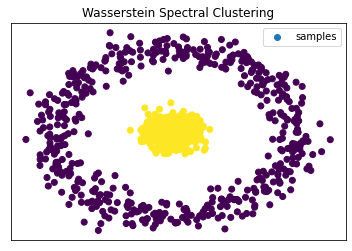

In [8]:
plt.figure()
plt.scatter(X_c[:, 0], X_c[:, 1], c=y_predict_c, marker='o', label='samples')
plt.xticks([])
plt.yticks([])
plt.legend(loc=0)
plt.title('Wasserstein Spectral Clustering')

In [9]:
SC_c = SpectralClustering(n_clusters=2, eigen_solver='arpack',gamma=10, assign_labels='kmeans',affinity="rbf").fit(X_c)
kmeans_c = KMeans(n_clusters=2).fit(X_c)

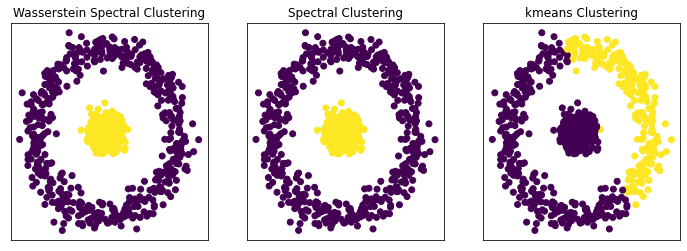

In [10]:
plt.figure(figsize=(12,4))
plt.subplot()
ax1 = plt.subplot(1, 3, 1)
ax1.title.set_text('Wasserstein Spectral Clustering')
plt.xticks([])
plt.yticks([])
ax1.scatter(X_c[:, 0], X_c[:, 1], c=y_predict_c, marker='o',label='data')
ax2 = plt.subplot(1, 3, 2)
ax2.title.set_text('Spectral Clustering')
plt.xticks([])
plt.yticks([])
ax2.scatter(X_c[:, 0], X_c[:, 1], c=SC_c.labels_, marker='o',label='data')
ax3 = plt.subplot(1, 3, 3)
ax3.title.set_text('kmeans Clustering')
plt.xticks([])
plt.yticks([])
ax3.scatter(X_c[:, 0], X_c[:, 1], c=kmeans_c.labels_, marker='o',label='data')
plt.show()

# Moons dataset

In [11]:
X_m, y_m = make_moons(1000, noise= 0.05)

In [12]:
y_predict_m=Wasserstein_SpectralClustering(X_m,2,10)

Text(0.5, 1.0, 'Wasserstein Spectral Clustering ')

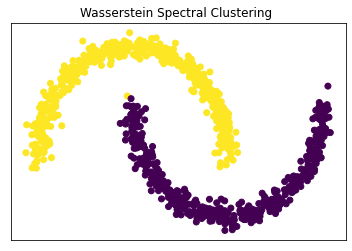

In [13]:
plt.figure()
plt.scatter(X_m[:, 0], X_m[:, 1], c=y_predict_m, marker='o')
plt.xticks([])
plt.yticks([])
plt.title('Wasserstein Spectral Clustering ')

In [17]:
SC_m = SpectralClustering(n_clusters=2, eigen_solver='arpack',gamma=10, assign_labels='kmeans',affinity="rbf").fit(X_m)
kmeans_m = KMeans(n_clusters=2).fit(X_m)

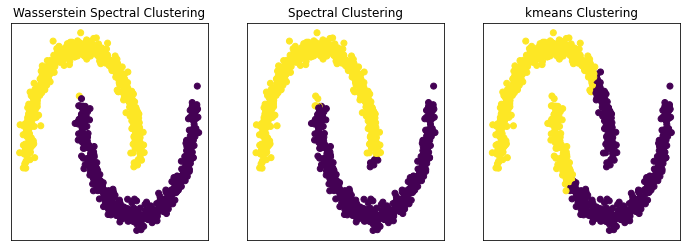

In [18]:
plt.figure(figsize=(12,4))
plt.subplot()
ax1 = plt.subplot(1, 3, 1)
ax1.title.set_text('Wasserstein Spectral Clustering')
plt.xticks([])
plt.yticks([])
ax1.scatter(X_m[:, 0], X_m[:, 1], c=y_predict_m, marker='o')
ax2 = plt.subplot(1, 3, 2)
ax2.title.set_text('Spectral Clustering')
plt.xticks([])
plt.yticks([])
ax2.scatter(X_m[:, 0], X_m[:, 1], c=SC_m.labels_, marker='o')
ax3 = plt.subplot(1, 3, 3)
ax3.title.set_text('kmeans Clustering')
plt.xticks([])
plt.yticks([])
ax3.scatter(X_m[:, 0], X_m[:, 1], c=kmeans_m.labels_, marker='o')
plt.show()